In [1]:
!pip install torchinfo
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 31.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import from_numpy as np2TT
from torchinfo import summary

from os.path import expanduser
from scipy.io import loadmat
from scipy.io import savemat
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import math
import json
import time
import mne
import sys
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


In [4]:
use_google_drive = True
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
config_path = '/content/drive/My Drive/A_EEG/CLEEGN/configs/ern-allchan/config.json'
train_anno_path = '/content/drive/My Drive/A_EEG/CLEEGN/configs/ern-allchan/set_train.json'
valid_anno_path = '/content/drive/My Drive/A_EEG/CLEEGN/configs/ern-allchan/set_valid.json'

# Autoencoder model class

In [6]:
class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return torch.permute(x, self.shape)

In [7]:
class CLEEGN(nn.Module):
    def __init__(self, n_chan, fs, N_F=20, tem_kernelLen=0.1):
        super(CLEEGN,self).__init__()
        self.n_chan = n_chan
        self.N_F = N_F
        self.fs = fs
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, n_chan, (n_chan, 1), padding="valid", bias=True),
            Permute2d((0, 2, 1, 3)),
            nn.BatchNorm2d(1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, N_F, (1, int(fs * tem_kernelLen)), padding="same", bias=True),
            nn.BatchNorm2d(N_F, eps=1e-3, momentum=0.99)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(N_F, N_F, (1, int(fs * tem_kernelLen)), padding="same", bias=True),
            nn.BatchNorm2d(N_F, eps=1e-3, momentum=0.99)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(N_F, n_chan, (n_chan, 1), padding="same", bias=True),
            nn.BatchNorm2d(n_chan, eps=1e-3, momentum=0.99)
        )
        self.conv5 = nn.Conv2d(n_chan, 1, (n_chan,1), padding="same", bias=True)

    def forward(self, x):
        # encoder
        x = self.conv1(x)
        x = self.conv2(x)
        # decoder
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.conv5(x)
        return x

# Load Metadata

In [8]:
def read_json(filepath):
    if filepath is None:
        return None
    fd = open(filepath, "r")
    content = json.load(fd)
    fd.close()
    return content

In [9]:
tra_anno = read_json(train_anno_path)
val_anno = read_json(valid_anno_path)
cfg = read_json(config_path)

SFREQ      = tra_anno["sfreq"]
NUM_EPOCHS = cfg["epochs"]
BATCH_SIZE = cfg["batch-size"]
if cfg["save-path"] is None:
    SAVE_PATH = os.path.dirname(train_anno_path)
else:
    SAVE_PATH = cfg["save-path"]

# Dataset

In [10]:
def segment_eeg(eeg, window_size=100, stride=50):
    """ Session EEG Signal by Slinding Window """
    n_chan, n_timep = eeg.shape
    tstamps, segments = [], []
    for i in range(0, n_timep, stride):
        seg = eeg[:,i: i + window_size]
        if seg.shape != (n_chan, window_size):
            break
        segments.append(seg)
        tstamps.append(i)

    return segments, tstamps

def create_dataset(x_fpath, y_fpath, fmt_terms, tmin, tmax, ch_names=None, win_size=4, stride=2):
    """ read mne set to numpy array """
    x_raw = mne.io.read_raw_eeglab(x_fpath.format(*fmt_terms[0]), verbose=0)
    sfreq = x_raw.info["sfreq"]
    win_size = math.ceil(win_size * sfreq)
    stride = math.ceil(stride * sfreq)
    nb_chan = len(x_raw.ch_names if ch_names is None else ch_names)
    tmin = math.ceil(tmin * sfreq)
    tmax = math.ceil(tmax * sfreq)

    X = np.zeros((0, nb_chan, win_size), dtype=np.float32)
    y = np.zeros((0, nb_chan, win_size), dtype=np.float32)
    for fmt_term in fmt_terms:
        x_raw = mne.io.read_raw_eeglab(x_fpath.format(*fmt_term), verbose=0)
        y_raw = mne.io.read_raw_eeglab(y_fpath.format(*fmt_term), verbose=0)
        if len(x_raw.ch_names) != len(y_raw.ch_names):
            raise ValueError(f"EEG channel should be matched, found {len(x_raw.ch_names)} and {len(y_raw.ch_names)}")

        x_content = x_raw[:, tmin: tmax][0]
        y_content = y_raw[:, tmin: tmax][0]
        if ch_names is not None:  # channel selection
            picks = [x_raw.ch_names.index(ch) for ch in ch_names]
            x_content = x_content[picks]
            y_content = y_content[picks]

        x_seg = np.array(segment_eeg(x_content, win_size, stride)[0])
        y_seg = np.array(segment_eeg(y_content, win_size, stride)[0])
        X = np.append(X, np.array(x_seg), axis=0)
        y = np.append(y, np.array(y_seg), axis=0)
    return X*1e+6, y*1e+6

In [11]:
x_train, y_train = create_dataset(
    os.path.join(tra_anno["x_basepath"], tra_anno["x_fpath"]),
    os.path.join(tra_anno["y_basepath"], tra_anno["y_fpath"]),
    tra_anno["fmt-terms"], tmin=tra_anno["tmin"], tmax=tra_anno["tmax"],
    ch_names=tra_anno["ch_names"], win_size=cfg["window-size"], stride=cfg["stride"]
)
x_train = np2TT(np.expand_dims(x_train, axis=1))
y_train = np2TT(np.expand_dims(y_train, axis=1))

x_valid, y_valid = create_dataset(
    os.path.join(val_anno["x_basepath"], val_anno["x_fpath"]),
    os.path.join(val_anno["y_basepath"], val_anno["y_fpath"]),
    val_anno["fmt-terms"], tmin=val_anno["tmin"], tmax=val_anno["tmax"],
    ch_names=val_anno["ch_names"], win_size=cfg["window-size"], stride=cfg["stride"]
)
x_valid = np2TT(np.expand_dims(x_valid, axis=1))
y_valid = np2TT(np.expand_dims(y_valid, axis=1))
print(x_train.size(), y_train.size(), x_valid.size(), y_valid.size())

trainset = torch.utils.data.TensorDataset(x_train, y_train)
tra_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
val_loader = torch.utils.data.DataLoader(
    validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

<ipython-input-10-6e48ebf12d92>:16: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  x_raw = mne.io.read_raw_eeglab(x_fpath.format(*fmt_terms[0]), verbose=0)
<ipython-input-10-6e48ebf12d92>:27: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  x_raw = mne.io.read_raw_eeglab(x_fpath.format(*fmt_term), verbose=0)
<ipython-input-10-6e48ebf12d92>:28: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  y_raw = mne.io.read_raw_eeglab(y_fpath.format(*fmt_term), verbose=0)
<ipython-inp

torch.Size([2392, 1, 56, 512]) torch.Size([2392, 1, 56, 512]) torch.Size([2392, 1, 56, 512]) torch.Size([2392, 1, 56, 512])


# Model Tracer

In [12]:
class Model_Tracer():
    def __init__(self, monitor="loss", mode="min", do_save=False, root=None, prefix="checkpoint"):
        if mode not in ["min", "max"]:
            raise ValueError("mode can only be `min` or `max`")
        self.mode = mode
        self.monitor = monitor
        self.do_save = do_save
        self.bound = np.inf if mode == "min" else (-np.inf)
        self.root = os.path.join(expanduser("~"), "Downloads") if root is None else root
        self.prefix = prefix

    def on_epoch_end(self, epoch, logs):
        if ((self.mode == "min" and logs[self.monitor] < self.bound) or
            (self.mode == "max" and logs[self.monitor] > self.bound)
        ):
            print("Epoch {}: {} is improved from {:.6f} to {:.6f}".format(
                epoch, self.monitor, self.bound, logs[self.monitor]
            ))
            self.bound = logs[self.monitor]
            if self.do_save:
                filename = "{}.pth".format(self.prefix)
                torch.save(logs, os.path.join(self.root, filename))

# TRAINING

In [43]:
def train(tra_loader, model, criterion, optimizer, verbose=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()  # switch to train mode

    log = ""
    ep_time0 = time.time()
    epoch_loss = np.zeros((len(tra_loader), ))
    for i, (x_batch, y_batch) in enumerate(tra_loader):
        # print(i, x_batch.shape, y_batch.shape)
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss[i] = loss.item()
        if verbose:
            print("\r{}".format(" " * len(log)), end="")
            log = "\r{}/{} - {:.4f} s - loss: {:.4f} - acc: nan".format(
                i + 1, len(tra_loader), time.time() - ep_time0, epoch_loss[i]
            )
            print(log, end="")

            if (i == 0 or i == len(tra_loader)-1):
                x_b_nump = x_batch.cpu().numpy()     # shape: (32,1,56,512)
                y_b_nump = y_batch.cpu().numpy()
                out = output.detach().cpu().numpy()
                plt.plot(x_b_nump[0,:,1,:][0,:])
                plt.plot(y_b_nump[0,:,1,:][0,:])
                plt.plot(out[0,:,1,:][0,:])
                plt.legend(('Original', 'Reference', 'CLEEGN'))
                plt.show()
                #plotSavePath = '/content/drive/MyDrive/A_EEG/CLEEGN/configs/ern-allchan/plotUpdate' + str(i) + '.jpg'
                #plt.savefig(plotSavePath)

    return epoch_loss.mean(axis=0)

In [44]:
def val(val_loader, model, criterion, verbose=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval() # switch to evaluation mode

    log = ""
    ep_time0 = time.time()
    epoch_loss = np.zeros((len(val_loader), ))
    for i, (x_batch, y_batch) in enumerate(val_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        with torch.no_grad():
            output = model(x_batch)
        # output = x_batch # DEBUG
        loss = criterion(output, y_batch)

        epoch_loss[i] = loss.item()
        if verbose:
            print("\r{}".format(" " * len(log)), end="")
            log = "\r{}/{} - {:.4f} s - loss: {:.4f} - acc: nan".format(
                i + 1, len(val_loader), time.time() - ep_time0, epoch_loss[i]
            )
            print(log, end="")
    return epoch_loss.mean(axis=0)

In [45]:
model = CLEEGN(n_chan=x_train.size()[2], fs=SFREQ, N_F=x_train.size()[2]).to(device)
summary(model, input_size=(BATCH_SIZE, 1, x_train.size()[2], x_train.size()[3]))

ckpts = [
    Model_Tracer(monitor="loss", mode="min"),
    Model_Tracer(monitor="val_loss", mode="min", do_save=True, root=SAVE_PATH, prefix=cfg["model_name"]),
]

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8, last_epoch=-1)

tra_time0 = time.time()
loss_curve = {"epoch": [], "loss": [], "val_loss": []}

1/75 - 0.9069 s - loss: 12.0801 - acc: nan

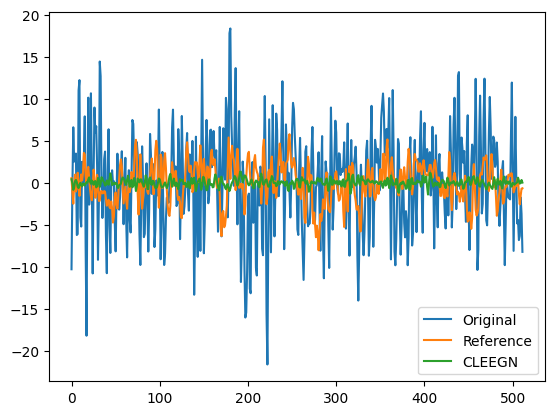

75/75 - 54.6351 s - loss: 3.0278 - acc: nan

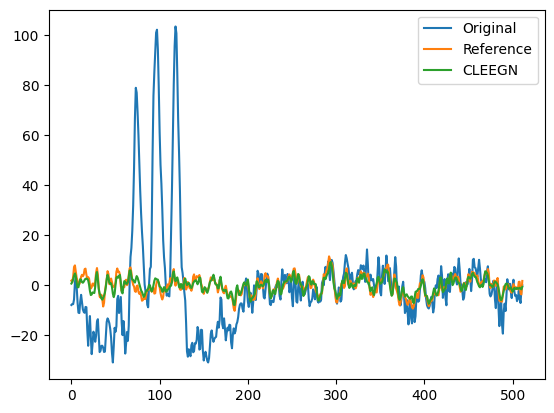

Epoch 1/10 - 66.21 s - loss: 4.7908 - val_loss: 7.5472 - lr: 1.000000e-03
Epoch 1: loss is improved from inf to 4.790766
Epoch 1: val_loss is improved from inf to 7.547203
1/75 - 0.8920 s - loss: 3.6138 - acc: nan

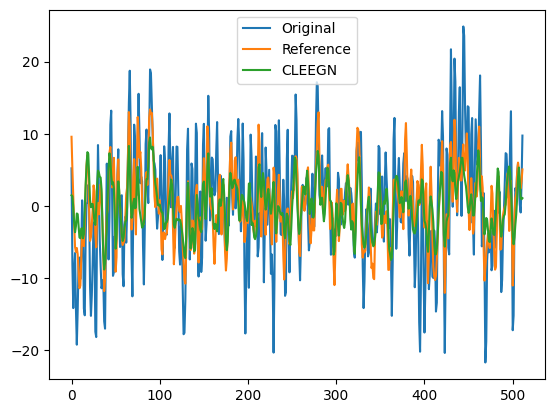

75/75 - 54.1209 s - loss: 3.2604 - acc: nan

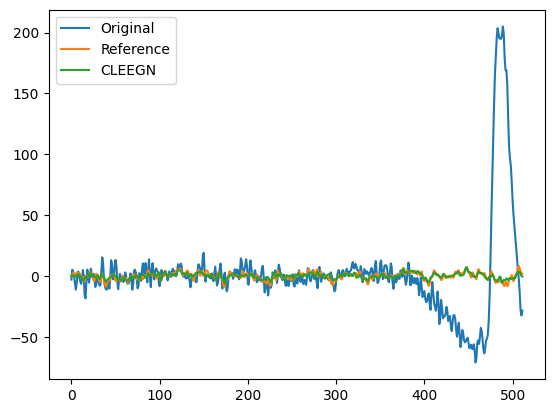

Epoch 2/10 - 130.43 s - loss: 3.1717 - val_loss: 6.9559 - lr: 8.000000e-04
Epoch 2: loss is improved from 4.790766 to 3.171696
Epoch 2: val_loss is improved from 7.547203 to 6.955935
1/75 - 0.9388 s - loss: 4.1411 - acc: nan

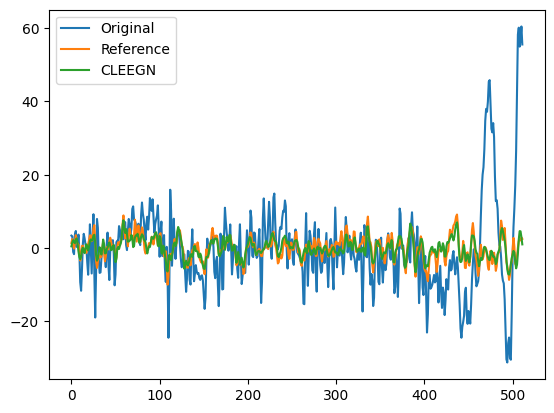

75/75 - 54.1210 s - loss: 2.6190 - acc: nan

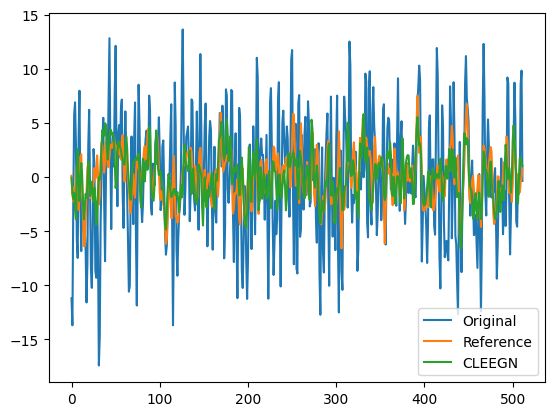

Epoch 3/10 - 194.87 s - loss: 2.9448 - val_loss: 7.6515 - lr: 6.400000e-04
Epoch 3: loss is improved from 3.171696 to 2.944783
1/75 - 0.8505 s - loss: 2.9182 - acc: nan

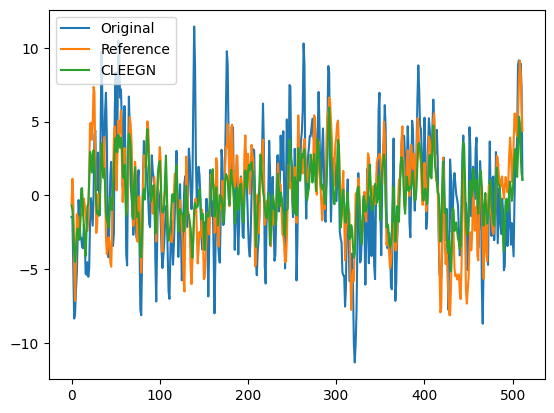

75/75 - 54.1126 s - loss: 3.0533 - acc: nan

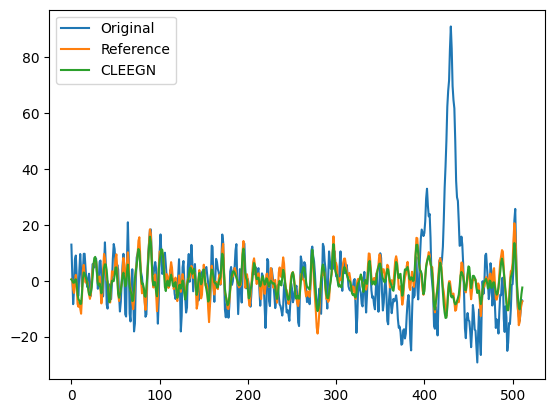

Epoch 4/10 - 259.44 s - loss: 2.7860 - val_loss: 6.9352 - lr: 5.120000e-04
Epoch 4: loss is improved from 2.944783 to 2.785963
Epoch 4: val_loss is improved from 6.955935 to 6.935152
1/75 - 0.8759 s - loss: 2.5202 - acc: nan

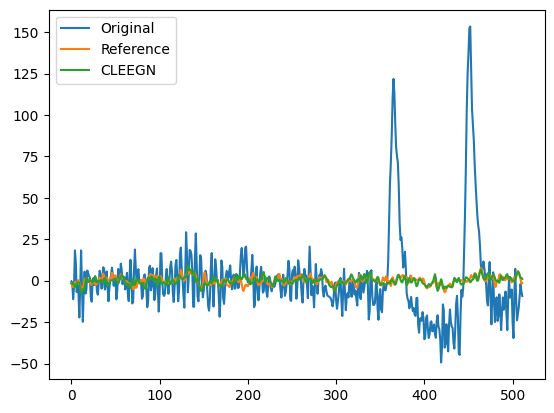

75/75 - 53.9106 s - loss: 2.3580 - acc: nan

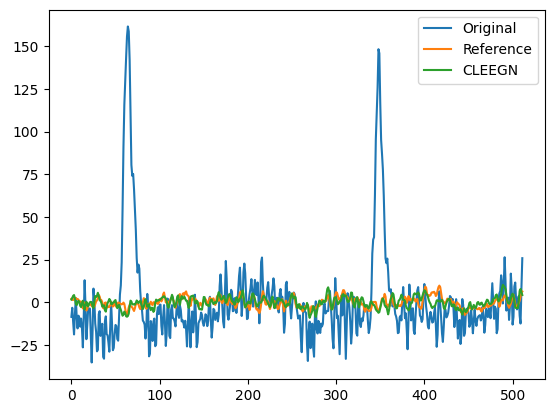

Epoch 5/10 - 323.73 s - loss: 2.6858 - val_loss: 6.8766 - lr: 4.096000e-04
Epoch 5: loss is improved from 2.785963 to 2.685761
Epoch 5: val_loss is improved from 6.935152 to 6.876580
1/75 - 0.8539 s - loss: 2.8793 - acc: nan

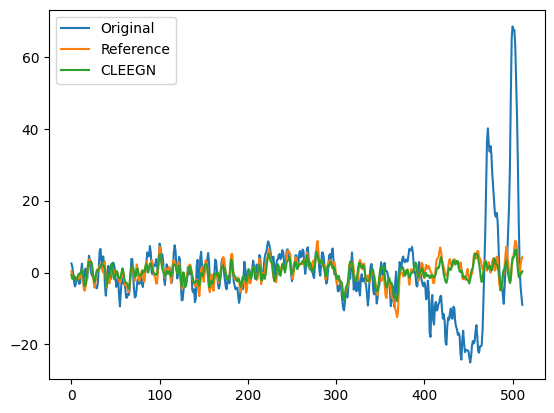

75/75 - 54.0875 s - loss: 2.5816 - acc: nan

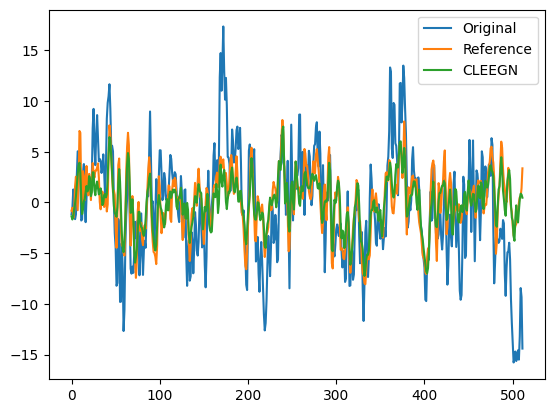

Epoch 6/10 - 388.07 s - loss: 2.6365 - val_loss: 6.7774 - lr: 3.276800e-04
Epoch 6: loss is improved from 2.685761 to 2.636476
Epoch 6: val_loss is improved from 6.876580 to 6.777354
1/75 - 0.9385 s - loss: 3.2186 - acc: nan

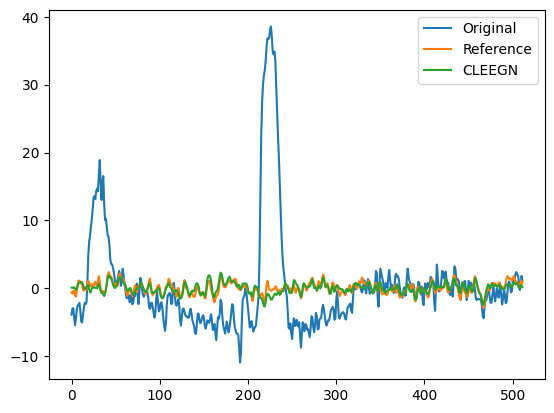

75/75 - 54.5112 s - loss: 2.3208 - acc: nan

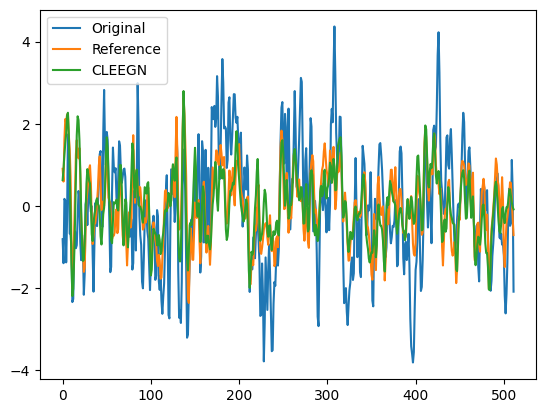

Epoch 7/10 - 452.70 s - loss: 2.5766 - val_loss: 6.9292 - lr: 2.621440e-04
Epoch 7: loss is improved from 2.636476 to 2.576614
1/75 - 0.9287 s - loss: 2.5856 - acc: nan

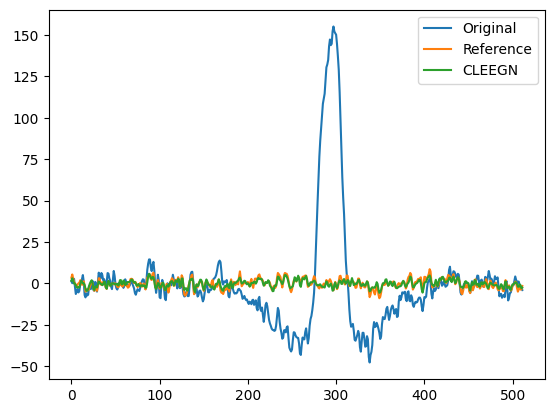

75/75 - 54.1477 s - loss: 2.3268 - acc: nan

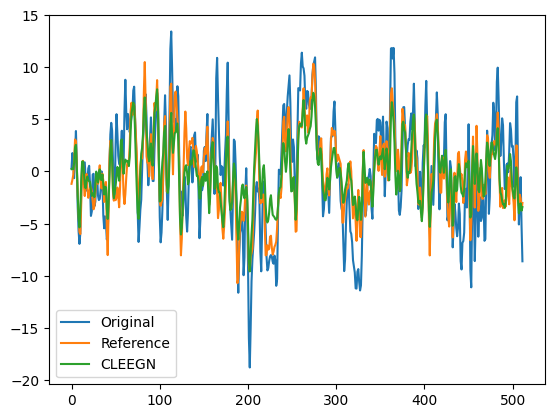

Epoch 8/10 - 517.26 s - loss: 2.5385 - val_loss: 6.4655 - lr: 2.097152e-04
Epoch 8: loss is improved from 2.576614 to 2.538497
Epoch 8: val_loss is improved from 6.777354 to 6.465487
1/75 - 0.8629 s - loss: 2.0164 - acc: nan

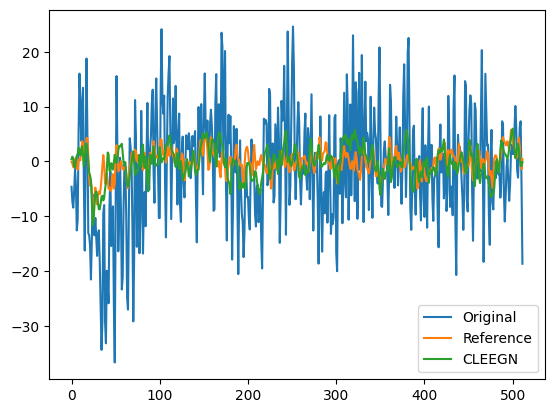

75/75 - 54.2161 s - loss: 2.3750 - acc: nan

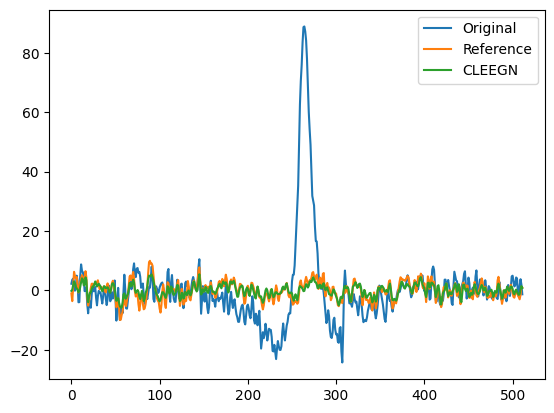

Epoch 9/10 - 581.97 s - loss: 2.5193 - val_loss: 6.6007 - lr: 1.677722e-04
Epoch 9: loss is improved from 2.538497 to 2.519306
1/75 - 0.8715 s - loss: 3.2300 - acc: nan

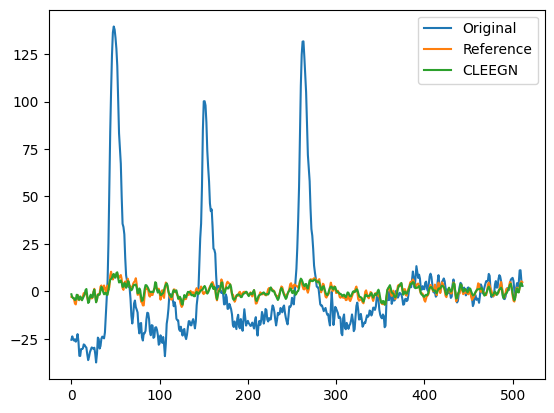

75/75 - 53.9925 s - loss: 2.3024 - acc: nan

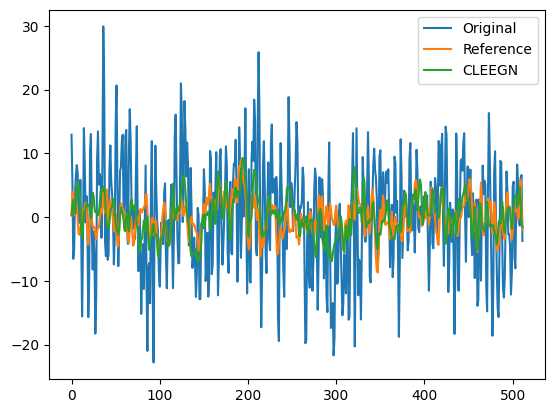

Epoch 10/10 - 646.39 s - loss: 2.4984 - val_loss: 7.4744 - lr: 1.342177e-04
Epoch 10: loss is improved from 2.519306 to 2.498357


In [46]:
for epoch in range(NUM_EPOCHS):
    loss = train(tra_loader, model, criteria, optimizer)

    """ validation """
    val_loss = val(val_loader, model, criteria)
    lr = optimizer.param_groups[-1]['lr']
    optimizer.step()
    scheduler.step()

    print("\rEpoch {}/{} - {:.2f} s - loss: {:.4f} - val_loss: {:.4f} - lr: {:e}".format(
        epoch + 1, NUM_EPOCHS, time.time() - tra_time0, loss, val_loss, lr
    ))
    state = dict(
        epoch=epoch + 1, min_loss=ckpts[0].bound, min_vloss=ckpts[1].bound,
        state_dict=model.state_dict(), loss=loss, val_loss=val_loss, learning_rate=lr
    )
    for ckpt in ckpts:
        ckpt.on_epoch_end(epoch + 1, state)
    loss_curve["epoch"].append(epoch + 1)
    loss_curve["loss"].append(loss)
    loss_curve["val_loss"].append(val_loss)
### End_Of_Train

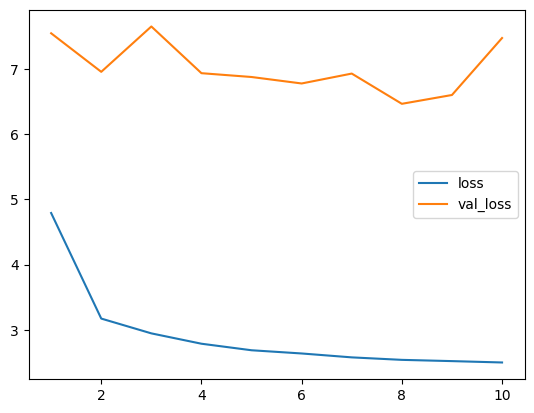

In [50]:
plt.plot(loss_curve['epoch'], loss_curve['loss'])
plt.plot(loss_curve['epoch'], loss_curve['val_loss'])
plt.legend(('loss', 'val_loss'))
plt.show()

In [51]:
modelSavePath = '/content/drive/My Drive/A_EEG/CLEEGN/models/test.pth'
torch.save(model.state_dict(), modelSavePath)
savemat(os.path.join(SAVE_PATH, "loss_curve.mat"), loss_curve)

# TEST/INFERENCE

<ipython-input-52-197420814b79>:45: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  hwin = signal.hann(window_size) + 1e-9


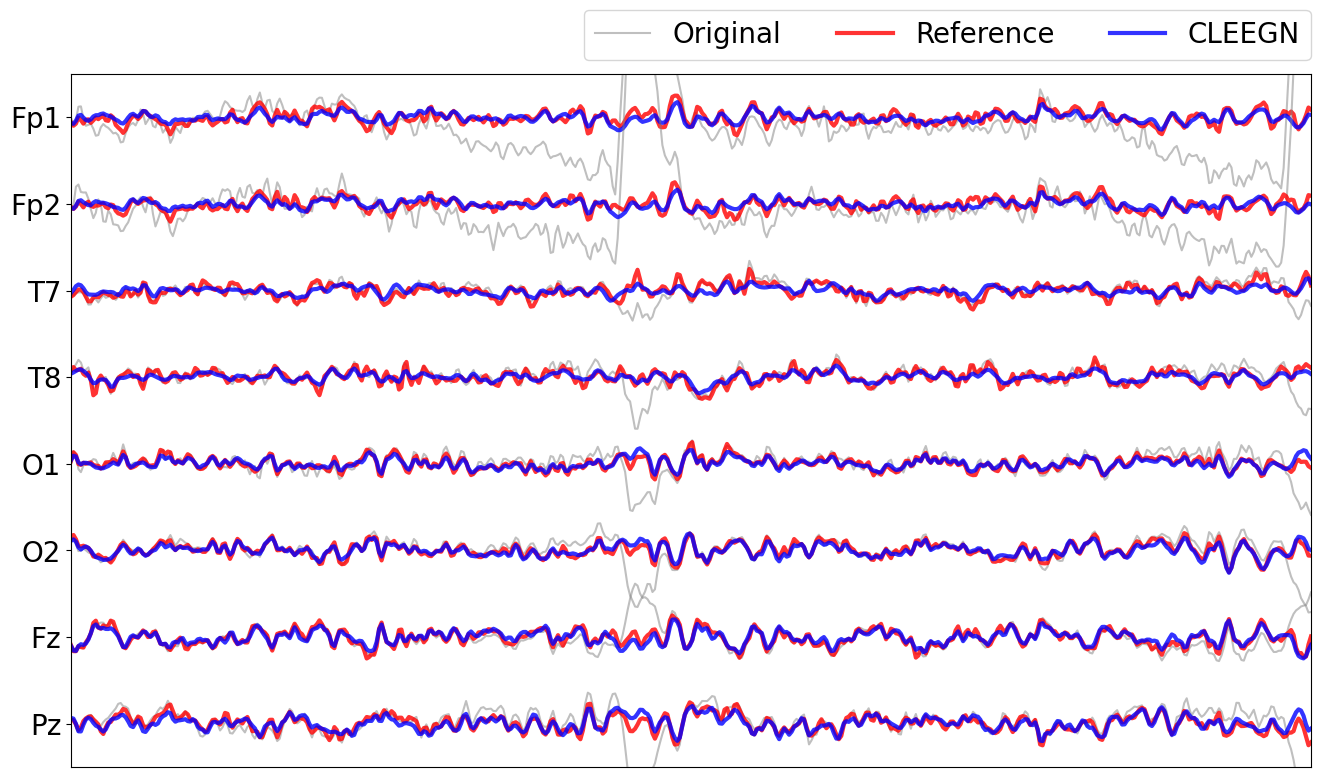

In [52]:
electrode = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'POz', 'PO8', 'O1', 'O2']

""" pyplot waveform visualization """
def viewARA(tstmps, data_colle, ref_i, electrode, titles=None, colors=None, alphas=None, ax=None):
    n_data = len(data_colle)
    titles = ["" for di in range(n_data)] if titles is None else titles
    alphas = [0.5 for di in range(n_data)] if alphas is None else alphas
    if colors is None:
        cmap_ = plt.cm.get_cmap("tab20", n_data)
        colors = [rgb2hex(cmap_(di)) for di in range(n_data)]

    picks_chs = ["Fp1", "Fp2", "T7", "T8", "O1", "O2", "Fz", "Pz"]
    picks = [electrode.index(c) for c in picks_chs]
    for di in range(n_data):
        data_colle[di] = data_colle[di][picks, :]
    if ax is None:
        ax = plt.subplot()
    for ii, ch_name in enumerate(picks_chs):
        offset = len(picks) - ii - 1
        norm_coef = 0.25 / np.abs(data_colle[ref_i][ii]).max()
        for di in range(n_data):
            eeg_dt = data_colle[di]
            ax.plot(tstmps, eeg_dt[ii] * norm_coef + offset,
                label=None if ii else titles[di], color=colors[di], alpha=alphas[di],
                linewidth=3 if alphas[di] > 0.6 else 1.5, # default=1.5
            )
    ax.set_xlim(tstmps[0], tstmps[-1])
    ax.set_ylim(-0.5, len(picks) - 0.5)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticks(np.arange(len(picks)))
    ax.set_yticklabels(picks_chs[::-1], fontsize=20)
    ax.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower right", borderaxespad=0, ncol=3, fontsize=20
    )

def ar_through_model(eeg_data, model, window_size, stride):
    model.eval()

    noiseless_eeg = np.zeros(eeg_data.shape, dtype=np.float32)
    hcoef = np.zeros(eeg_data.shape[1], dtype=np.float32)

    hwin = signal.hann(window_size) + 1e-9
    for i in range(0, noiseless_eeg.shape[1], stride):
        tstap, LAST_FRAME = i, False
        segment = eeg_data[:, tstap: tstap + window_size]
        if segment.shape[1] != window_size:
            tstap = noiseless_eeg.shape[1] - window_size
            segment = eeg_data[:, tstap:]
            LAST_FRAME = True
        with torch.no_grad():
            segment = np.expand_dims(segment, axis=0)
            data = np2TT(np.expand_dims(segment, axis=0))
            data = data.to(device, dtype=torch.float)
            pred_segment = model(data)
            pred_segment = np.array(pred_segment.cpu()).astype(np.float32)
        noiseless_eeg[:, tstap: tstap + window_size] += \
            pred_segment.squeeze() * hwin
        hcoef[tstap: tstap + window_size] += hwin

        if LAST_FRAME:
            break
    noiseless_eeg /= hcoef

    return noiseless_eeg

if __name__ == "__main__":
    import argparse
    #parser = argparse.ArgumentParser(description="removal artifact from multi-channel EEG data")
    #parser.add_argument("--mat-path", required=True, type=str, help="path to EEG data (.mat)")
    #parser.add_argument("--model-path", required=True, type=str, help="path to pre-trained model (.pth)")
    #args = parser.parse_args()

    #mat_path = '/content/drive/MyDrive/A_EEG/CLEEGN/sampleData/ERN_S02_exSam.mat'
    #mat_path = '/content/drive/MyDrive/A_EEG/CLEEGN/sampleData/test.mat'
    mat_path = '/content/drive/MyDrive/A_EEG/CLEEGN/sampleData/Data_S18.mat'

    model_path = '/content/drive/MyDrive/A_EEG/CLEEGN/configs/ern-allchan/bc-56chan.pth'

    mat = loadmat(mat_path)
    dt_polluted, dt_ref = mat["x_test"], mat["y_test"]

    ### temporary fixed mode
    state_path = os.path.join(model_path)
    state = torch.load(state_path, map_location="cpu")
    model = CLEEGN(n_chan=56, fs=128.0, N_F=56).to(device)
    model.load_state_dict(state["state_dict"])
    #model.load_state_dict(torch.load(model_path))
    dt_cleegn = ar_through_model(
        dt_polluted, model, math.ceil(4.0 * 128.0), math.ceil(1.0 * 128.0)
    )

    start = 1500
    x_min, x_max = start, start + 500
    x_data = dt_polluted[:, x_min: x_max]
    y_data = dt_ref[:, x_min: x_max]
    p_data = dt_cleegn[:, x_min: x_max]
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    viewARA(
        np.linspace(0, math.ceil(x_data.shape[-1] / 128.0), x_data.shape[-1]),
        [x_data, y_data, y_data, p_data], 1, electrode,
        titles=["Original", "", "Reference", "CLEEGN"], colors=["gray", "gray", "red", "blue"], alphas=[0.5, 0, 0.8, 0.8], ax=ax
    )
    plt.show()